In [1]:
%reload_ext autoreload

In [2]:
%autoreload 2
import math
import numpy as np

from BoseHubbardHamiltonian_class import BoseHubbardHamiltonian

from qiskit.quantum_info import Pauli, Operator
from qiskit.quantum_info import SparsePauliOp

from symmer.operators import PauliwordOp, QuantumState
from symmer.projection import QubitTapering 

import rustworkx as rx
from qiskit_nature.second_q.hamiltonians.lattices import (
    BoundaryCondition,
    HyperCubicLattice,
    Lattice,
    LatticeDrawStyle,
    LineLattice,
    SquareLattice,
    TriangularLattice,
)

from symmer.operators import IndependentOp
from scipy.linalg import eigh, eig
import scipy.sparse

C:\Users\User\OneDrive\Desktop\Martina\Tesi\tapenv\lib\site-packages\cotengra\hyperoptimizers\hyper.py:34: UserWarning: Couldn't import `kahypar` - skipping from default hyper optimizer and using basic `labels` method instead.
  warnings.warn(


In [3]:
#line lattice 
num_nodes = 3 #number of sites in the lattice 
boundary_condition = BoundaryCondition.OPEN #open lattice
line_lattice = LineLattice(num_nodes=num_nodes, boundary_condition=boundary_condition)

In [31]:
#Hamiltonian of the system given the number of sites in the lattice and the number of qubits 
num_qubits = 2
num_nodes = 3
H_instance = BoseHubbardHamiltonian(num_nodes, num_qubits, line_lattice)

energy_values =[3.,1.]
energy_param_ratio = energy_values[0]/energy_values[1]

H_q = H_instance.get_H(energy_values[0],energy_values[1])
H = PauliwordOp.from_qiskit(H_q)
#print(H)

In [32]:
H_instance.total_number
total_number = PauliwordOp.from_qiskit(H_instance.total_number)
#print(total_number) 

In [33]:
#Selezione autostati comuni H e total_number

commutator = H*total_number-total_number*H
commutator_sparse_matrix = commutator.to_sparse_matrix
commutator_array = commutator_sparse_matrix.toarray()


Commut_eigenvalues, Commut_eigenvectors =eig(commutator_array) # autovalori e autovettori del commutatore 

common_eigenvectors = Commut_eigenvectors[Commut_eigenvalues == 0.0] #autovettori relativi ad autovalori nulli


H_sparse_matrix = H.to_sparse_matrix
H_array = H_sparse_matrix.toarray()
H_eigenvalues, H_eigenvectors =eig(H_array) #autovalori e autovettori hamiltoniana

# Supponiamo di voler trovare gli autovettori fisici dell'operatore H  |v> basati sul commutatore: [H, n]|v> = 0
# Calcoliamo il prodotto elemento per elemento tra il commutatore e gli autovettori di H
product = commutator_sparse_matrix * H_eigenvectors

# Troviamo gli indici degli autovettori di H che soddisfano la condizione di essere autovettori fisici: 
indices = np.where(np.all(product == 0, axis=1))[0]

# Selezioniamo gli autovettori fisici corrispondenti agli indici trovati
physical_eigenvectors = H_eigenvectors[indices] 
physical_eigenvalues = H_eigenvalues[indices]

print(physical_eigenvalues)


[ 2.66453526e-15+0.j -2.24264069e+00+0.j  2.88372144e+01+0.j
 -9.93984862e+00+0.j  1.09375186e+01+0.j  4.08139542e-01+0.j
  8.00000000e+00+0.j]


In [34]:
eigenvalues_matrix_init = []
param_ratio_list = []

In [35]:
#matrice degli autovalori relativi a diversi valori di t/U
eigenvalues_matrix_init.append(physical_eigenvalues)

#vettore con i valori di t/U da mettere su asse x
param_ratio_list.append(energy_param_ratio)
print(param_ratio_list)
print(eigenvalues_matrix_init)

[3.0]
[array([ 2.66453526e-15+0.j, -2.24264069e+00+0.j,  2.88372144e+01+0.j,
       -9.93984862e+00+0.j,  1.09375186e+01+0.j,  4.08139542e-01+0.j,
        8.00000000e+00+0.j])]


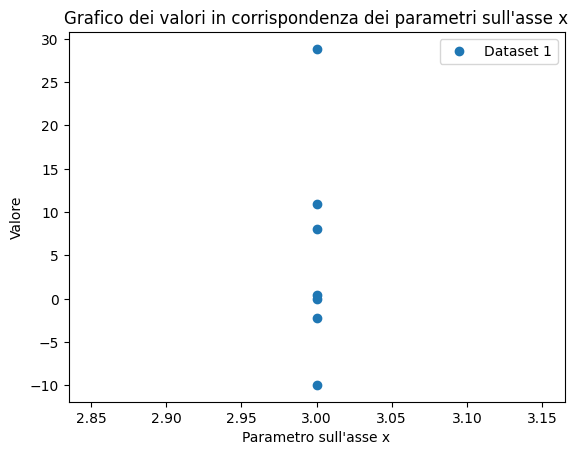

In [36]:
import matplotlib.pyplot as plt
import numpy as np

x_values = param_ratio_list
y_values = eigenvalues_matrix_init

for i in range(len(x_values)):
    plt.plot([x_values[i]] * len(y_values[i]), y_values[i],marker='o', linestyle='none', label=f'Dataset {i+1}')

# Aggiunta di etichette agli assi
plt.xlabel('Parametro sull\'asse x')
plt.ylabel('Valore')

# Aggiunta di una legenda
plt.legend()

# Aggiunta di un titolo al grafico
plt.title('Grafico dei valori in corrispondenza dei parametri sull\'asse x')

# Visualizzazione del grafico
plt.show()

In [37]:
#IndipendentOp represents algebraically independent sets of Pauli operators for stabilizer manipulation/projections
IndependentOp.symmetry_generators(H, commuting_override=True)

1 IZIZIZ

In [38]:
taper_hamiltonian = QubitTapering(H)
taper_hamiltonian.stabilizers.rotate_onto_single_qubit_paulis()


-1 IZIIII

In [39]:
#TAPERED HAMILTONIAN +

sec_array = [1]
#sec_array = [1,1,1,1,1,1]
ham_tap_p= taper_hamiltonian.taper_it(sector=sec_array)
number_tap_p= taper_hamiltonian.taper_it(sector=sec_array, aux_operator=total_number)
#print(ham_tap_p)
#print("\n",number_tapered)

In [40]:
#Selezione autostati comuni H e total_number

commutator_tap_p = ham_tap_p*number_tap_p-number_tap_p*ham_tap_p
commutator_tap_p_sparse_matrix = commutator_tap_p.to_sparse_matrix
commutator_tap_p_array = commutator_tap_p_sparse_matrix.toarray()


Commut_eigenvalues, Commut_eigenvectors =eig(commutator_tap_p_array) # autovalori e autovettori del commutatore 

common_eigenvectors = Commut_eigenvectors[Commut_eigenvalues == 0.0] #autovettori relativi ad autovalori nulli


ham_tap_p_sparse_matrix = ham_tap_p.to_sparse_matrix
ham_tap_p_array = ham_tap_p_sparse_matrix.toarray()
ham_tap_p_eigenvalues, ham_tap_p_eigenvectors =eig(ham_tap_p_array) #autovalori e autovettori hamiltoniana

# Supponiamo di voler trovare gli autovettori fisici dell'operatore H |v> basati sul commutatore: [H, n]|v> = 0
# Calcoliamo il prodotto elemento per elemento tra il commutatore e gli autovettori di H
product = commutator_tap_p_sparse_matrix * ham_tap_p_eigenvectors

# Troviamo gli indici degli autovettori di H che soddisfano la condizione di essere autovettori fisici: 
indices = np.where(np.all(product == 0, axis=1))[0]

# Selezioniamo gli autovettori fisici corrispondenti agli indici trovati
physical_eigenvectors_tap_p = ham_tap_p_eigenvectors[indices] 
physical_eigenvalues_tap_p = ham_tap_p_eigenvalues[indices]

print(physical_eigenvalues_tap_p)

[18.72792206+0.j  6.        +0.j -1.53553878+0.j]


In [16]:
#TAPERED HAMILTONIAN -

sec_array = [-1]
#sec_array = [-1,-1,-1,-1,-1,-1]
ham_tap_n= taper_hamiltonian.taper_it(sector=sec_array)
number_tap_n= taper_hamiltonian.taper_it(sector=sec_array, aux_operator=total_number)
#print('Tapered Hamiltonian:\n')
#print(ham_tap_p) #sector = -1

In [30]:
#Selezione autostati comuni H e total_number

commutator_tap_n = ham_tap_n * number_tap_n - number_tap_n * ham_tap_n
commutator_tap_n_sparse_matrix = commutator_tap_n.to_sparse_matrix
commutator_tap_n_array = commutator_tap_n_sparse_matrix.toarray()


Commut_eigenvalues, Commut_eigenvectors =eig(commutator_tap_n_array) # autovalori e autovettori del commutatore 

common_eigenvectors = Commut_eigenvectors[Commut_eigenvalues == 0.0] #autovettori relativi ad autovalori nulli


ham_tap_n_sparse_matrix = ham_tap_n.to_sparse_matrix
ham_tap_n_array = ham_tap_n_sparse_matrix.toarray()
ham_tap_n_eigenvalues, ham_tap_n_eigenvectors =eig(ham_tap_n_array) #autovalori e autovettori hamiltoniana

# Supponiamo di voler trovare gli autovettori fisici dell'operatore H |v> basati sul commutatore: [H, n]|v> = 0
# Calcoliamo il prodotto elemento per elemento tra il commutatore e gli autovettori di H
product = commutator_tap_n_sparse_matrix * ham_tap_n_eigenvectors

# Troviamo gli indici degli autovettori di H che soddisfano la condizione di essere autovettori fisici: 
indices = np.where(np.all(product == 0, axis=1))[0]

# Selezioniamo gli autovettori fisici corrispondenti agli indici trovati
physical_eigenvectors_tap_n = ham_tap_n_eigenvectors[indices] 
physical_eigenvalues_tap_n = ham_tap_n_eigenvalues[indices]

print(physical_eigenvalues_tap_n)

[]


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data for plotting
t = np.arange(0.0, 64 , 1)
s1 = merged_eigenvalues_sorted
s2 = eigenvalues_sorted 

fig, ax = plt.subplots()

# Primo set di punti
ax.scatter(t, s1, label='H_rid', color = 'b', marker='o', s=15)

# Sovrapponi il secondo set di punti
ax.scatter(t, s2, label='H_model', color = 'r',  marker='x', s = 120)

ax.set(xlabel='', ylabel='Hamiltonian eigenvalues',
       title='Eigenvalues of model Hamiltonian H and tapered Hamiltonian H_rid')
ax.grid()
ax.legend()  # Aggiungi la legenda per distinguere i set di punti

ax.set_xticks([])


fig.savefig("test.png")
plt.show()